In [1]:
import pandas
from sklearn import (decomposition, preprocessing)
import numpy
import flowio
import seaborn
import matplotlib.pyplot as plt

In [2]:
fcs_data = flowio.FlowData('features.fcs')
npy_data = numpy.reshape(fcs_data.events, (-1, fcs_data.channel_count))
df = pandas.DataFrame(npy_data, columns=[c["PnN"] for c in fcs_data.channels.values()])

In [3]:
df.columns = ["feat_%s" % col if col not in ["set", "label"] else "meta_%s" % col for col in df]
df["index"] = numpy.arange(df.shape[0])

In [4]:
df = df[df["meta_label"] != -1]
df.loc[df["meta_set"] == 100, "meta_set"] = 1

In [5]:
df = df.drop(columns=(df.columns[df.var() == 0]))
df = df.drop(columns=df.filter(regex="saturation").columns)

In [6]:
dfs = []
for idx, gdf in df.groupby("meta_set"):
    X = gdf.drop(columns=["meta_set", "meta_label"])
    tmp_df = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(X), columns=X.columns)
    tmp_df["meta_set"] = gdf["meta_set"].values
    tmp_df["meta_label"] = gdf["meta_label"].values
    dfs.append(tmp_df)
scaled_df = pandas.concat(dfs)

In [7]:
embed_df = pandas.DataFrame(index=df.index)

In [8]:
tmp = decomposition.PCA(n_components=2).fit_transform(scaled_df.drop(columns=["meta_set", "meta_label"]).values)
embed_df["feat_pca_0"] = tmp[:, 0]
embed_df["feat_pca_1"] = tmp[:, 1]

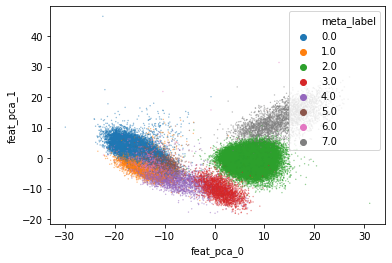

In [9]:
seaborn.scatterplot(data=pandas.concat([embed_df, df], axis=1), hue="meta_label", x="feat_pca_0", y="feat_pca_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

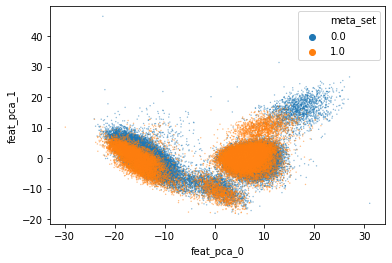

In [10]:
seaborn.scatterplot(data=pandas.concat([embed_df, df], axis=1), hue="meta_set", x="feat_pca_0", y="feat_pca_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

In [12]:
export_df = pandas.concat([embed_df[["feat_pca_0", "feat_pca_1"]], df[["feat_aream07", "feat_intensitymcsiglec8pe", "feat_thicknessmaxm06", "meta_label", "index"]]], axis=1)
for col in export_df:
    if(export_df[col].dtype == numpy.int64):
        export_df[col] = export_df[col].astype(numpy.int32)

export_df.reset_index(drop=True).to_feather("./demo.feather", compression="uncompressed")